# Firing rate associations reviewed

In [1]:
%load_ext autoreload
%autoreload 2
%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run ../../cell_type_spatial_plot_functions.py
import os.path
import shutil
from scipy.stats import mannwhitneyu, pearsonr, wilcoxon, binned_statistic,friedmanchisquare
import matplotlib.image as mpimg
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
import matplotlib.patches as mpatches
from rpy2 import robjects
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
import logging

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath="/adata/projects/autopi_mec",dlcModelPath="/adata/models",sessionFileName="sessionList")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /adata/projects/autopi_mec
dlcModelPath: /adata/models
Reading /adata/projects/autopi_mec/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
for ses in sSessions:
    ses.load_parameters_from_files() 

In [4]:
fn = myProject.dataPath+"/beate/results/cells.csv"
print("Loading", fn)
cells = pd.read_csv(fn)

fn=myProject.dataPath+"/beate/results/myMaps.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    myMaps = pickle.load(fp)
    
fn=myProject.dataPath+"/beate/results/mapCorDf.csv"
print("Loading",fn)
dfMapCor = pd.read_csv(fn)

fn=myProject.dataPath+"/beate/results/res_ifr.csv"
print("Loading",fn)
dfAsso = pd.read_csv(fn)

fn=myProject.dataPath+"/results/myMapStats.csv"
print("Loading",fn)
dfMapStats = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/beate/results/cells.csv
Loading /adata/projects/autopi_mec/beate/results/myMaps.pickle
Loading /adata/projects/autopi_mec/beate/results/mapCorDf.csv
Loading /adata/projects/autopi_mec/beate/results/res_ifr.csv
Loading /adata/projects/autopi_mec/results/myMapStats.csv


In [5]:
fn=myProject.dataPath+"/results/mySpatialAutos.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    mySpatialAutos = pickle.load(fp)
    
fn=myProject.dataPath+"/results/gc_crosscorrs.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    gcCrossCor = pickle.load(fp)
    
fn=myProject.dataPath+"/results/gc_pairs.csv"
print("Loading:",fn)
gc_pairs = pd.read_csv(fn)

fn=myProject.dataPath+"/results/gc_stcfm_10_0.5.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    gcStcfm = pickle.load(fp)
    
fn=myProject.dataPath+"/results/gc_pairs_stcfm.pickle"
print("Loading:",fn)
with open(fn, 'rb') as fp: 
    gcStcfm_pairs = pickle.load(fp)

fn=myProject.dataPath+"/results/gc_stcfm_rotations.pickle"
print("Loading:",fn)
with open(fn, 'rb') as fp: 
    gcStcfmRot = pickle.load(fp)
    
fn=myProject.dataPath+f"/results/gc_crosscorrs_10_0.5_shuffle200.pickle"
print("Loading:",fn)
with open(fn, 'rb') as fp: 
    gcStcfm_shuffle = pickle.load(fp)

Loading /adata/projects/autopi_mec/results/mySpatialAutos.pickle


KeyboardInterrupt: 

In [ ]:
fn=myProject.dataPath+"/results/gc_stcfm_rotations_stats.pickle"
print("Loading:",fn)
with open(fn, 'rb') as fp: 
    gcStcfm_pairs_stats = pickle.load(fp)

In [ ]:
clu_table_path = myProject.dataPath+"/beate/results/clu_table.csv"
if not os.path.exists(clu_table_path):
    dataframe_paths = [f'/adata/electro/{ses.subject}/{ses.name}/clu_table' for ses in sSessions if os.path.exists(f'/adata/electro/{ses.subject}/{ses.name}/clu_table')]
    dataframes = [pd.read_csv(dataframe_paths[i]) for i,j in enumerate(dataframe_paths)]
    clu_table = pd.concat(dataframes, axis=0)
    dfs=[]
    for ses in sSessions:
        if os.path.exists(f'/adata/electro/{ses.subject}/{ses.name}/clu_table'):
            ct=pd.read_csv(f'/adata/electro/{ses.subject}/{ses.name}/clu_table')
            if not 'session' in ct.columns:
                ct['session']=np.tile(ses.name,ct.shape[0])
                ct['cluId']=ct.session +'_'+ ct['clu_ids'].astype(str)
                ct=ct.drop('clu_ids', axis=1)
            #ct.to_csv(f'/adata/electro/{ses.subject}/{ses.name}/clu_table')
            dfs.append(ct)
    clu_table=pd.concat(dfs, axis=0)
    clu_table.to_csv(clu_table_path, index=False)
else:
    clu_table=pd.read_csv(clu_table_path)

In [ ]:
cells_clu=cells.merge(right = clu_table, on=['cluId','session'], how='left')
cells_clu

In [9]:
dfAsso

,ifrAsso_circ80,ifrAsso_circ80_1,ifrAsso_circ80_2,ifrAsso_all_task,ifrAsso_all_task_1,ifrAsso_all_task_2,ifrAsso_light,ifrAsso_dark,ifrAsso_light_1,ifrAsso_light_2,...,ifrAsso_all_light,ifrAsso_all_dark,ifrAsso_all_light_1,ifrAsso_all_light_2,ifrAsso_all_dark_1,ifrAsso_all_dark_2,id1,id2,session,mouse
0,0.030297,0.053780,0.028184,0.010274,-0.039841,0.055586,0.096286,-0.052800,0.118738,0.069120,...,0.037765,0.028417,0.047909,0.037370,0.063915,-0.021246,mn8578-30112021-0107_20,mn8578-30112021-0107_22,mn8578-30112021-0107,mn8578
1,0.148658,NaN,0.046427,0.012770,0.020178,0.013211,0.012922,0.019109,0.007255,0.028409,...,0.007180,0.033439,-0.018284,0.036602,0.012316,0.045122,mn8578-30112021-0107_20,mn8578-30112021-0107_45,mn8578-30112021-0107,mn8578
2,0.253657,NaN,0.099010,0.060967,0.014657,0.091961,0.027939,0.056633,0.021974,0.034539,...,0.012925,0.058657,0.008971,0.033792,-0.027572,0.093420,mn8578-30112021-0107_20,mn8578-30112021-0107_48,mn8578-30112021-0107,mn8578
3,0.119246,0.059349,0.151159,0.107913,0.124348,0.087860,0.158898,0.141992,0.173330,0.141171,...,0.105603,0.024872,0.128955,0.083441,0.034289,0.017939,mn8578-30112021-0107_20,mn8578-30112021-0107_57,mn8578-30112021-0107,mn8578
4,-0.260463,0.001020,0.019946,0.125390,0.113941,0.135644,0.090521,0.032972,0.089229,0.091752,...,0.016503,0.023077,-0.080732,0.073498,0.094033,-0.018577,mn8578-30112021-0107_20,mn8578-30112021-0107_67,mn8578-30112021-0107,mn8578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463856,0.161176,0.143053,0.183847,0.160608,0.148895,0.155985,0.456520,0.314729,0.460620,0.448065,...,0.088104,0.153246,0.065695,0.119849,0.132708,0.136837,jp499-25052023-0108_528,jp499-25052023-0108_533,jp499-25052023-0108,jp499
463857,-0.038132,-0.036831,-0.044720,0.058437,0.076127,0.032713,0.083165,0.026237,0.074743,0.092652,...,0.046994,0.047708,-0.016167,0.085391,0.021306,0.069843,jp499-25052023-0108_528,jp499-25052023-0108_535,jp499-25052023-0108,jp499
463858,0.104348,0.097725,0.138373,0.094061,0.150661,0.057834,0.315049,0.237751,0.322789,0.305874,...,0.074726,0.108523,-0.127481,0.222994,0.045773,0.132129,jp499-25052023-0108_530,jp499-25052023-0108_533,jp499-25052023-0108,jp499
463859,-0.037305,-0.047557,-0.019040,-0.035020,-0.050573,-0.021086,0.060317,-0.011700,0.041239,0.087757,...,-0.023000,-0.043053,-0.016177,-0.029001,-0.030675,-0.061555,jp499-25052023-0108_530,jp499-25052023-0108_535,jp499-25052023-0108,jp499


In [ ]:
selection="gridCell_AND"
dfAsso = dfAsso[(dfAsso.id1.isin(cells[cells[selection]==True].cluId))&((dfAsso.id2.isin(cells[cells[selection]==True].cluId)))]
dfAsso

In [ ]:
## include only sessions with 5 grid cells or more (at least 10 gc pairs)
ses_counts = dfAsso.mouse.value_counts()
dfAsso = dfAsso[dfAsso.mouse.isin(ses_counts[ses_counts >= 10].index)]
dfAsso

In [ ]:
dfAsso_sh = dfAsso.merge(cells_clu, left_on='id1', right_on='cluId', how='left').rename(columns={'shank': 'shank_id1'})
dfAsso_sh = dfAsso_sh.merge(cells_clu, left_on='id2', right_on='cluId', how='left').rename(columns={'shank': 'shank_id2'})

# Filter rows where shank_id1 is different from shank_id2
dfAsso_sh = dfAsso_sh[dfAsso_sh['shank_id1'] != dfAsso_sh['shank_id2']]

dfAsso_sh

In [ ]:
df_sorted = dfAsso_sh.sort_values(by='ifrAsso_circ80_1')
df_sorted

In [14]:
dfAsso_sh.id1[dfAsso_sh.ifrAsso_circ80_1>0.8]
#dfAsso_sh.id2[dfAsso_sh.ifrAsso_circ80_1>0.8]

181     mn8578-23122021-0108_70
519    jp3120-25052022-0107_258
Name: id1, dtype: object

In [ ]:
def plotSingleFiringAsso(ax,dfAsso,cond1,cond2,printStats=False):
    
    # use to set meaningful condition names
    labelDict = {"ifrAsso_circ80_1": "RF1",
                "ifrAsso_circ80_2": "RF2",
                "ifrAsso_all_dark": "AutoPI Dark",
                "ifrAsso_all_light": "AutoPI Light"}
    
    myCol=(0.30588235, 0.53333333, 0.58039216)
    ax.scatter(dfAsso[cond1],dfAsso[cond2],s=2,alpha=0.3,color=myCol)
    ax.set_xlim(-0.3,1)
    ymax=1
    ax.set_ylim(-0.3,ymax)
    ax.set_xlabel(labelDict[cond1])
    ax.set_ylabel(labelDict[cond2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    r,p = pearsonr(dfAsso[cond1],dfAsso[cond2])
    
    #instead of pearson r use crossed mixed effects model (code in R) for p value
    pandas2ri.activate()
    lme4 = importr('lme4')
    robjects.globalenv['data'] = dfAsso
    robjects.r('''
        library(lmerTest)
        # Fit the mixed model in R
        model <- lmer(ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2), data = data)
        # Get the summary
        model_summary <- summary(model)
        fixed_effects <- model_summary$coefficients
    ''')
    model_summary = robjects.r('model_summary')
    print(model_summary)
    fixed_effects = robjects.r('fixed_effects')
    print(f'r={fixed_effects[1][0]}, p={fixed_effects[1][4]}')
    p=fixed_effects[1][4]#; r=fixed_effects[1][0]
    
    n = len(dfAsso[cond1])
    
    ax.text(-0.2, ymax*0.90, "N = {}".format(n),fontsize=10)
    ax.text(-0.2, ymax*0.72, "r = {:.2f}".format(r),fontsize=10)
    #ax.text(-0.2, ymax*0.90, "r= {:.2f}".format(r),fontsize=10)
    if printStats:
        print("N:{}, r:{}, p:{}".format(n,r,p))
    

In [ ]:
custom_long_name = 'Wilcoxon Test'
custom_short_name = 'Wilcoxon'
custom_func = wilcoxon
custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

def plotFiringAssoPerMouseAndConditions(ax,dfAsso,printStats=False, stats_test='Mann-Whitney'):

    conds1 = ["ifrAsso_circ80_1","ifrAsso_circ80_1","ifrAsso_circ80_1","ifrAsso_all_light","ifrAsso_all_dark_1","ifrAsso_all_light_1"]
    conds2 = ["ifrAsso_circ80_2","ifrAsso_all_dark","ifrAsso_all_light","ifrAsso_all_dark","ifrAsso_all_dark_2","ifrAsso_all_light_2"]

    dfCounts = dfAsso.groupby(["mouse"])["mouse"].value_counts()
    mice = [ i for i in dfCounts.index]
    dfN = pd.DataFrame({"mouse":mice,
                 "n":dfCounts.to_numpy()})
    miceToKeep = dfN.mouse[dfN.n>10] # keep mice with at least 10 grid cell pairs
    
    # get the r value per mouse
    dfMouseUnit = pd.DataFrame()
    for c1,c2 in zip(conds1,conds2):
        df = dfAsso[[c1,c2, "mouse"]]
        df = df[df.mouse.isin(miceToKeep)]

        # get the r value for each mouse
        dfMouseR = df.groupby(["mouse"]).apply(getRValue,c1,c2).reset_index()
        dfMouseR.columns=["mouse","r"]
        dfMouseUnit = pd.concat([dfMouseUnit,pd.DataFrame({"mouse":dfMouseR.mouse,
                                           "condition": "{}-{}".format(c1,c2),
                                           "r": dfMouseR.r})])

    addLabelToDfAsso(dfMouseUnit)



    #sns.boxplot(y="label",x="r", data = dfMouseUnit,order=labelOrderAsso())
    #sns.stripplot(data=dfMouseUnit, y="label",x="r",order = labelOrderAsso(),alpha=0.7)
    
    myCol=(0.30588235, 0.53333333, 0.58039216)
    sns.boxplot(data=dfMouseUnit ,y="label",x="r",showfliers=False,order=labelOrderAsso(),color=myCol)
    sns.stripplot(data=dfMouseUnit, y="label",x="r",order = labelOrderAsso(),alpha=0.7,color=myCol,
                   size=5,edgecolor='#373737', linewidth=1)
    
    
    
    ax.set_xlim(-0.0,1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Asso. stability (r)")
    ax.set_ylabel("")
    ax.tick_params(axis='y', which='major', labelsize=8)

    n = len(dfMouseUnit["r"][dfMouseUnit.label=="RF1-RF2"]) 
    ax.text(0.10, 0, f"N = {n}",fontsize=9)
    
    # statistics
    if printStats:
        pairs=[('RF1-RF2','RF1-Light'), ('RF1-RF2','RF1-Dark')]
        number_of_comparisons=15 #BH correction for 15 possible comparisons
        annotator = Annotator(ax, data=dfMouseUnit, pairs=pairs, x='r', y="label", order=labelOrderAsso(), orient='h')
        annotator.configure(test=stats_test, loc='outside', line_height=0.01, text_offset=0.001, line_offset=0.001,verbose=2,
                            pvalue_thresholds=[[(1e-4)/number_of_comparisons, "****"], [(1e-3)/number_of_comparisons, "***"], 
                                               [(1e-2)/number_of_comparisons, "**"], [0.05/number_of_comparisons, "*"], [1,"ns"]])
        annotator.apply_and_annotate()
        
    if printStats:
        s,p1 = wilcoxon(dfMouseUnit["r"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["r"][dfMouseUnit.label=="RF1-Dark"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs RF1-Dark")
        print("N={} S={} {}".format(n,s,formatPValue(p1)))

        s,p2 = wilcoxon(dfMouseUnit["r"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["r"][dfMouseUnit.label=="RF1-Light"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs RF1-Light")
        print("N={} S={} {}".format(n,s,formatPValue(p2)))

        s,p = wilcoxon(dfMouseUnit["r"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["r"][dfMouseUnit.label=="Light-Dark"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs Light-Dark")
        print("N={} S={} {}".format(n,s,formatPValue(p)))

        
def getRValue(df,c1,c2):
    """
    Get the number of sessions
    """
    return pearsonr(df[c1],df[c2])[0]


def addLabelToDfAsso(df):
    df["label"]=np.nan
    df.label[df.condition=='ifrAsso_circ80_1-ifrAsso_circ80_2'] = "RF1-RF2"   
    df.label[df.condition=='ifrAsso_circ80_1-ifrAsso_all_dark'] = "RF1-Dark"   
    df.label[df.condition== 'ifrAsso_circ80_1-ifrAsso_all_light'] = "RF1-Light"
    df.label[df.condition=='ifrAsso_all_light-ifrAsso_all_dark'] = "Light-Dark"    
    df.label[df.condition=="ifrAsso_all_dark_1-ifrAsso_all_dark_2"] = "Dark1-Dark2"    
    df.label[df.condition=="ifrAsso_all_light_1-ifrAsso_all_light_2"] = "Light1-Light2"    

def labelOrderAsso():
    return ["RF1-RF2","RF1-Light","RF1-Dark","Light-Dark","Light1-Light2","Dark1-Dark2"]



In [ ]:
def plotFiringAssociations(mainSpec,dfAsso):
    
    ncols=1
    nrows=2
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=mainSpec) # two rows to give space for letters above the plots
            
    #ax = fig.add_subplot(plotSpec[0,0]) # add an axes to the figure
    #plotSingleFiringAsso(ax,dfAsso,cond1 = "ifrAsso_circ80_1",cond2 = "ifrAsso_circ80_2")

    ax = fig.add_subplot(plotSpec[0]) # add an axes to the figure
    plotSingleFiringAsso(ax,dfAsso,cond1 = "ifrAsso_circ80_1",cond2 = "ifrAsso_all_dark", printStats=True)

    ax = fig.add_subplot(plotSpec[1]) # add an axes to the figure
    plotFiringAssoPerMouseAndConditions(ax,dfAsso, printStats=True, stats_test=custom_test)

    #ax = fig.add_subplot(titleSpec[0]) # add an axes to the letters
    #ax.text(0.0,1.0, 'a', style='normal',fontsize=12, weight="bold")
    #ax.text(0.66,1.0, 'b', style='normal',fontsize=12, weight="bold")
    #ax.axis("off")
    

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -4388.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5262 -0.5700 -0.0248  0.5282  5.6773 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001553 0.01246 
 id2      (Intercept) 0.0000000 0.00000 
 Residual             0.0054000 0.07348 
Number of obs: 1868, groups:  id1, 398; id2, 347

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -4.873e-03  1.920e-03  2.118e+02  -2.539   0.0118 *  
ifrAsso_circ80_1  8.118e-01  9.390e-03  1.859e+03  86.449   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.140
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

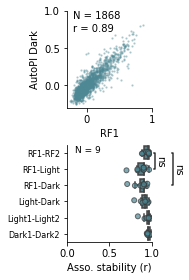

In [28]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1.4
nrows=2
fig = plt.figure(figsize=(ncols*colSize, (nrows+0.1)*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure
plotFiringAssociations(mainSpec[0],dfAsso_sh)

In [29]:
def plot_waveforms_neuronexus(mainSpec,clu_id):
    mouse=clu_id.split('-')[0]
    date=clu_id.split('-')[1]
    appendix=clu_id.split('_')[0].split('-')[2]
    name=f"{mouse}-{date}-{appendix}"
    path=f"/adata/electro/{mouse}/{name}/"
    clu=clu_id.split('_')[1]
    ses = Kilosort_session(name=name,path=path)
    ses.load_parameters_from_files()
    stl = Spike_train_loader()
    stl.load_spike_train_kilosort(ses)
    cg = Cell_group(stl)
    index = np.where([neuron.cluster_number == int(clu) for neuron in cg.neuron_list])[0][0]
    n = cg.neuron_list[index]
    df = Dat_file_reader(file_names=[f"{path}{mouse}-{date}_01.dat"], n_channels=65)
    sw = Spike_waveform(session=ses, dat_file_reader=df, spike_train=n.spike_train)
    sw.mean_waveform(block_size=200, channels=np.asarray([n for n in range(64)]), n_spikes=2000) #calculate the mean waveforms for all channels over a time interval of 200 ms (greater time intervals gave errors)
    upper_sites = [((n+1)*16-1) for n in range(4)] + [((n+1)*16-2) for n in range(4)]
    ch_map = np.load(f"{path}channel_map.npy")
    rows = np.tile(np.flip(range(9)), 4)
    rows = np.repeat(rows,2,axis=0)
    #cols = (np.repeat([[1,0],[3,2],[5,4],[7,6]],9,axis=0))
    cols = (np.repeat([[1,0],[4,3],[7,6],[10,9]],9,axis=0))
    cols = cols.flatten()
    ax_map = [(row, col) for (row, col) in zip(rows, cols)]

    # get the n_channels channels with the highest amplitudes
    n_channels = 8
    amplitudes = [abs(max(sw.mean_waveforms[n,:])) + abs(min(sw.mean_waveforms[n,:])) for n in range(sw.mean_waveforms.shape[0])]
    channel_amp_list = [(c,a) for c,a in zip(amplitudes, range(sw.mean_waveforms.shape[0]))]
    channel_amp_dict = dict(channel_amp_list)
    amp_sorted_channels = [channel_amp_dict[a] for a in sorted(channel_amp_dict)]
    channels = amp_sorted_channels[:(sw.mean_waveforms.shape[0]-n_channels-1):-1]

    # plot the wave forms 
    layout = gridspec.GridSpecFromSubplotSpec(ncols=11, nrows=9, subplot_spec=mainSpec, width_ratios=[1,1,0.3,1,1,0.3,1,1,0.3,1,1])
    n_ax = 0
    for n in range(sw.mean_waveforms.shape[0]):
        if n in upper_sites:
            ax = fig.add_subplot(layout[ax_map[n_ax][0],(ax_map[n_ax][1]-1):(ax_map[n_ax][1])])
            n_ax += 2
        else:
            ax = fig.add_subplot(layout[ax_map[n_ax]])
            n_ax += 1
        if ch_map[n] in channels:
            ax.plot(sw.mean_waveforms[np.squeeze(ch_map[n]),:], 'm')
        else:
            ax.plot(sw.mean_waveforms[np.squeeze(ch_map[n]),:])    
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        #ax.set_ylabel(np.squeeze(ch_map[n]), rotation=0)
        ax.set_ylabel('')
        ax.yaxis.set_ticks([])
        ax.set_ylim(sw.mean_waveforms[:,:].min(), sw.mean_waveforms[:,:].max())
        ax.get_xaxis().set_visible(False)
    
    
from spikeA.Spike_waveform import Spike_waveform


R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -4388.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5262 -0.5700 -0.0248  0.5282  5.6773 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001553 0.01246 
 id2      (Intercept) 0.0000000 0.00000 
 Residual             0.0054000 0.07348 
Number of obs: 1868, groups:  id1, 398; id2, 347

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -4.873e-03  1.920e-03  2.118e+02  -2.539   0.0118 *  
ifrAsso_circ80_1  8.118e-01  9.390e-03  1.859e+03  86.449   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.140
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

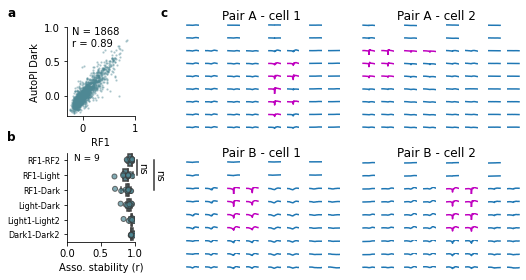

In [30]:
rowSize,colSize= figurePanelDefaultSize()
ncols=4
nrows=2
fig = plt.figure(figsize=(ncols*colSize, (nrows+0.1)*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=5, nrows=4, width_ratios=[1,0.1,1,0.1,1], height_ratios=[0.1,1,0.2,1]) # create a GridSpec object to a figure

plotFiringAssociations(mainSpec[1:,0],dfAsso_sh)
plot_waveforms_neuronexus(clu_id='mn8578-23122021-0108_70', mainSpec=mainSpec[1,2])
plot_waveforms_neuronexus(clu_id='mn8578-23122021-0108_141', mainSpec=mainSpec[1,4])
plot_waveforms_neuronexus(clu_id='jp3120-25052022-0107_258', mainSpec=mainSpec[3,2])
plot_waveforms_neuronexus(clu_id='jp3120-25052022-0107_306', mainSpec=mainSpec[3,4])

ax = fig.add_subplot(mainSpec[:,:]) # add an axes to the figure
ax.text(0,0.97, 'a', style='normal',fontsize=12, weight="bold")
ax.text(0.42,0.96, 'Pair A - cell 1', style='normal',fontsize=12)
ax.text(0.76,0.96, 'Pair A - cell 2', style='normal',fontsize=12)
ax.text(0.42,0.44, 'Pair B - cell 1', style='normal',fontsize=12)
ax.text(0.76,0.44, 'Pair B - cell 2', style='normal',fontsize=12)

ax.text(0.3,0.97, 'c', style='normal',fontsize=12, weight="bold")
ax.text(0,0.5, 'b', style='normal',fontsize=12, weight="bold")
ax.axis("off")
fig.savefig(dataPath+"/results/Reviewer2Fig_Asso.png", bbox_inches="tight",dpi=1200)

In [33]:
def plot_ifr_example(mainSpec, n1Name="mn8578-23122021-0108_70",n2Name="mn8578-23122021-0108_141", 
                     startTimeCirc80=200,endTimeCirc80=300,
                     startIndexTask=2000,
                     maxY = 60,labels=["Grid cell 1", "Grid cell 2"]):
    
    
    
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=1, width_ratios=[1,1,1.5, 1.5], subplot_spec=mainSpec[0])
    
    sessionName = n1Name.split("_")[0]
    cluId1 = n1Name.split("_")[1]
    cluId2 = n2Name.split("_")[1]
    cluIndex1 = cells[cells.cluId==n1Name].index[0]
    cluIndex2 = cells[cells.cluId==n2Name].index[0]
    
    sSes = [s for s in sSessions if s.name == sessionName][0]
    ses = [s for s in myProject.sessionList if s.name == sessionName][0]

    prepareAutopipySession(ses)
   
    
    sSes.load_parameters_from_files()
    load_spike_train(sSes)
    load_pose_data(sSes)

    getSessionConditionIntervals(ses,sSes) # function defined in setup.py
    getSearchHomingIntervals(ses,sSes)

    
    
    nNames = pd.Series([n.name for n in sSes.cg.neuron_list])
    
    n1Index = [ i for i,name in enumerate(nNames) if name == n1Name][0]
    n2Index = [ i for i,name in enumerate(nNames) if name == n2Name][0]
    n1 = sSes.cg.neuron_list[n1Index]
    n2 = sSes.cg.neuron_list[n2Index]
    
    
    ## plot maps of the circ80_1
    cond = "circ80_1"
    ax = fig.add_subplot(plotSpec[0]) # add an axes to the figure
    plotMap(ax,myMaps[cond][cluIndex1,:,2:],title="",titleY=0.95,titleFontSize=8,cmap = 'viridis')
    ax.set_title(labels[0],fontsize=9)
    ax = fig.add_subplot(plotSpec[1]) # add an axes to the figure
    plotMap(ax,myMaps[cond][cluIndex2,:,2:],title="",titleY=0.95,titleFontSize=8,cmap = 'viridis')
    ax.set_title(labels[1],fontsize=9)
    
    
    ## ifr of circ80_1
    cond = "circ80_1"
    for n in [n1,n2]:
        n.spike_train.unset_intervals()
        n.spike_train.set_intervals(ses.intervalDict[cond])
        n.spike_train.instantaneous_firing_rate(bin_size_sec = 0.100, sigma = 1,outside_interval_solution="remove")
    
    tIndices = np.logical_and(n1.spike_train.ifr[2]>startTimeCirc80,n1.spike_train.ifr[2]<endTimeCirc80)
    ax = fig.add_subplot(plotSpec[2]) # add an axes to the figure
    timeArray = n1.spike_train.ifr[2][tIndices]-startTimeCirc80
    ax.plot(timeArray, n1.spike_train.ifr[0][tIndices],label=labels[0])
    ax.plot(timeArray, n2.spike_train.ifr[0][tIndices], alpha=0.5,color="red", label=labels[1])
    #,n2.spike_train.ifr[0]) 
    ax.set_ylim(0,maxY)
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Firing rate (Hz)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=9,loc=1)
    ax.set_title("RF1",fontsize=9)
    r = pearsonr(n1.spike_train.ifr[0].flatten(),n2.spike_train.ifr[0].flatten())[0]
    ax.text((endTimeCirc80-startTimeCirc80)*0.01, maxY*0.9, "r = {:.2f}".format(r),fontsize=10)
    lenCircIfr = len(n1.spike_train.ifr[0][tIndices])
    
    ## ifr of the task
    cond = "searchPath_dark"
    for n in [n1,n2]:
        n.spike_train.unset_intervals()
        n.spike_train.set_intervals(ses.intervalDict[cond])
        n.spike_train.instantaneous_firing_rate(bin_size_sec = 0.100, sigma = 1,outside_interval_solution="remove")
    
    
    ## we need the same time period as the first condition, 
    ## during the AutoPI task the time is not continuous in the same condition
    
   
    
    ifr1 = n1.spike_train.ifr[0][startIndexTask:(startIndexTask+lenCircIfr)]
    ifr2 = n2.spike_train.ifr[0][startIndexTask:(startIndexTask+lenCircIfr)]
    
    
    ax = fig.add_subplot(plotSpec[3]) # add an axes to the figure
    ax.plot(timeArray,ifr1 ,label=labels[0])
    ax.plot(timeArray, ifr2, alpha=0.5,color="red", label=labels[1])
    #,n2.spike_train.ifr[0]) 
    ax.set_ylim(0,maxY)
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Firing rate (Hz)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=9,loc=1)
    ax.set_title("AutoPI Search-Dark",fontsize=9)
    r = pearsonr(n1.spike_train.ifr[0].flatten(),n2.spike_train.ifr[0].flatten())[0]
    ax.text((endTimeCirc80-startTimeCirc80)*0.01, maxY*0.9, "r = {:.2f}".format(r),fontsize=10)
    
    

In [34]:
def plot_two_ifr_examples(spec):
    """
    Figure that explains what IFR associations between grid cells are.
    """
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=2, subplot_spec=spec[0])    
    plot1Spec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotSpec[0])
    plot2Spec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotSpec[1])

    plot_ifr_example(plot1Spec,n1Name="jp1686-28042022-0107_170",n2Name="jp1686-28042022-0107_214",
                     startTimeCirc80=400,endTimeCirc80=435,maxY = 100, labels=["Cell 1", "Cell 2"],
                startIndexTask=150)

    plot_ifr_example(plot2Spec, n1Name="jp3129-05062022-0108_251",n2Name="jp3129-05062022-0108_255",
                 startTimeCirc80=320,endTimeCirc80=355, maxY=100, labels=["Cell 3", "Cell 4"],
                startIndexTask=2000)

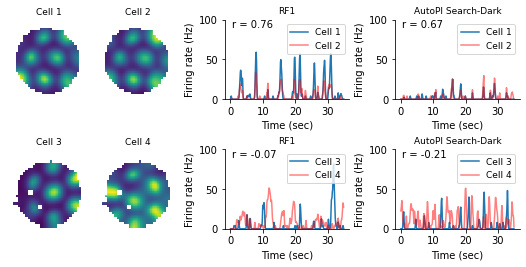

In [35]:
rowSize,colSize= figurePanelDefaultSize()
ncols=4
nrows=2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
plotSpec = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure
plot_two_ifr_examples(plotSpec)
plt.show()
fig.savefig(dataPath+"/results/Reviewer2Fig_IFRex.png", bbox_inches="tight",dpi=1200)

In [36]:
def plotMap(ax,myMap,title="",titleY=0.95,titleFontSize=10,transpose=True,cmap="jet",vmin=0):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(myMap.T,origin="lower",cmap=cmap,interpolation=None, vmin=vmin)
    else:
        ax.imshow(myMap,origin="lower",cmap=cmap,interpolation=None, vmin=vmin)
    ax.set_title(title,y=titleY,fontsize=titleFontSize)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    
    
def plotSpatialCrosscorrelation(ax,cc, removePadding=False,showCenter=True,showPeak=False,useFieldDetection=True,showExpectedPeak=False,xOffset=None,yOffset=None,cm_per_bin=None,title="",
                               field_detection_neighborhood_size=3.5, field_detection_max_min_threshold=0.1, field_detection_min_peak_value=0.2):
    """
    Function to plot spatial crosscorrelation or spike-triggered short-time cross-firing rate map
    
    Arguments:
    ax: axes
    cc: 2D numpy array with the spatial crosscorrelation or ststcfrm
    removePadding: whether to remove padding when plotting. Padding are columns or rows with only invalid data. See spatialCrosscorrelationRemovePadding()
    showCenter: boolean, will plot lines and a dot to show the center of the map
    showPeak: boolean, will plot lines and a dot to show the peak of the map (where the maximal value is)
    useFieldDetection: boolean, if showPeak is True and useFiedlDetection is True, will use field detection to find the closest peak to the center
    showExpectedPeak: boolean, use when debugging, can plot lines and dot to show the expected peak in the map
    xOffset, yOffset: use with showExpectedPeak, this is the xOffset and yOffset 
    
    
    """
    
    cx = cc.copy()
    if removePadding:
        cx=spatialCrosscorrelationRemovePadding(cx,extraPadding=0)
    
    if np.nanmin(cx) < 0: # assumes that the values are from -1 to 1 (Pearson correlation coefficients and not rate), add +1 to values so that negative values are not clamped at 0
        plotMap(ax,cx+1,title="",titleY=0.95,titleFontSize=8,vmin=np.nanmin(cx+1)) # this plots the transpose of the map
    else :
        plotMap(ax,cx,title="",titleY=0.95,titleFontSize=8, vmin=np.nanmin(cx)) # this plots the transpose of the map
    
    if showCenter:
        # crosscorrelation and autocorrelations always have an odd number of bins
        # for example if 7x7, then mid point should be at index 3,3
        midPoint=(cx.shape[0]/2-0.5,cx.shape[1]/2-0.5)
        #print("Center:",midPoint)
        ax.plot([0,cx.shape[0]], [midPoint[1],midPoint[1]],"--",color="black", alpha=0.5) # horizontal line for the center of the cc
        ax.plot([midPoint[0],midPoint[0]],[0,cx.shape[1]],"--",color="black", alpha=0.5) # vertical line for the center of the cc
        ax.scatter([midPoint[0]],[midPoint[1]],color="black",alpha=0.5,s=1)
    
    if showExpectedPeak: # use for testing the functions
        ax.plot([0,cx.shape[1]], [midPoint[1]+yOffset/cm_per_bin,midPoint[1]+yOffset/cm_per_bin],"--",color="gray", alpha=0.8) # expected offset for testing, horizontal line
        ax.plot([midPoint[0]+xOffset/cm_per_bin, midPoint[0]+xOffset/cm_per_bin],[0,cx.shape[0]],"--",color="gray", alpha=0.8) # expected offset for testing, vertical line
        ax.scatter([midPoint[0]+xOffset/cm_per_bin], [midPoint[1]+yOffset/cm_per_bin],color="red", alpha=0.8) # expected offset for testing, vertical line
    
    if showPeak:
        cxm = cx.copy()
        if useFieldDetection==False:
            
            cxm[np.isnan(cxm)]=np.nanmin(cxm) # set invalid values to the minimal value in the array, won't be detected as peak.
            peakLoc = np.unravel_index(np.argmax(cxm, axis=None), cxm.shape)
            print("Location of the peak value:", peakLoc)
        if useFieldDetection==True:
            _,_,_,_,_,_,_,peakLoc,_,_,_ = crosscorrelation_map_stats(cxm,cm_per_bin=2, field_detection_neighborhood_size=field_detection_neighborhood_size, field_detection_max_min_threshold=field_detection_max_min_threshold, field_detection_min_peak_value=field_detection_min_peak_value)
            print("Location of the detected field peak:", peakLoc)
        
        ax.scatter([peakLoc[0]], [peakLoc[1]],color="pink", alpha=0.8) # real peak in the crosscorrelation
        ax.plot([0,cx.shape[1]], [peakLoc[1],peakLoc[1]],"--",color="pink", alpha=0.8) # expected offset for testing, horizontal line
        ax.plot([peakLoc[0], peakLoc[0]],[0,cx.shape[0]],"--",color="pink", alpha=0.8) # expected offset for testing, vertical line
    ax.set_title(title)  
def plot_map_and_cross_corr(mainSpec, sessionName, myMaps,cells, gc_pairs, gcCrossCor,  env="circ80_1",nCells=10):
    """
    Plot firing rate maps and spatial crosscorrelations
    """
    
    cluIds = cells[(cells.gridCell_AND==True) & (cells.session==sessionName)].cluId.head(nCells)
    indices = cluIds.index
    
    ncols=len(cluIds)+1
    nrows=len(cluIds)+1
    mapSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=mainSpec[0])
    
   
    # vertical maps on the left-most column
    for i, (cluId, ind) in enumerate(zip(cluIds,indices)):
        ax = fig.add_subplot(mapSpec[i+1,0]) # add an axes to the figure
        m = myMaps[env][ind,:,:]
        plotMap(ax,m,titleY=0.95,titleFontSize=8,title = "")
        title = i # "{:.2f} Hz".format(np.nanmax(m))
        ax.text(m.shape[0]/2, m.shape[1]+3, title,fontsize=7,horizontalalignment='center',verticalalignment='center',)
        x = np.cos(np.linspace(0,2*np.pi,100))*40/3 + m.shape[0]/2
        y = np.sin(np.linspace(0,2*np.pi,100))*40/3 + m.shape[1]/2
        ax.plot(x,y, "--",color="grey", alpha=0.5)

    # horizontal maps at the top
    for i, (cluId, ind) in enumerate(zip(cluIds,indices)):
        ax = fig.add_subplot(mapSpec[0,i+1]) # add an axes to the figure
        m = myMaps[env][ind,:,:]
        plotMap(ax,m,titleY=0.95,titleFontSize=8,title = "")
        title = i # "{:.2f} Hz".format(np.nanmax(m))
        ax.text(m.shape[0]/2, m.shape[1]+3, title,fontsize=7,horizontalalignment='center',verticalalignment='center',)
        x = np.cos(np.linspace(0,2*np.pi,100))*40/3 + m.shape[0]/2
        y = np.sin(np.linspace(0,2*np.pi,100))*40/3 + m.shape[1]/2
        ax.plot(x,y, "--",color="grey", alpha=0.5)
    
    # spatial autocorrelations
    for i, (cluId, ind) in enumerate(zip(cluIds,indices)):
        ax = fig.add_subplot(mapSpec[i+1,i+1]) # add an axes to the figure
        m = mySpatialAutos[env][ind,:,:]+1
        mSmall = spatialCrosscorrelationRemovePadding(m)
        plotSpatialCrosscorrelation(ax,m,removePadding=True,showCenter=False)
        title = "{0}-{1}".format(i,i)
        ax.text(mSmall.shape[0]/2+1, mSmall.shape[1]+6, title,fontsize=7,horizontalalignment='center',verticalalignment='center',)
    
    # spatial cross-correlation
    for i, (cluId1, ind) in enumerate(zip(cluIds,indices)):
        for j, (cluId2, ind) in enumerate(zip(cluIds,indices)):
            if (j>i):
                ax = fig.add_subplot(mapSpec[i+1,j+1]) # add an axes to the figure
                ccIndex = gc_pairs[(gc_pairs.cluId1==cluId1) & 
                                   (gc_pairs.cluId2==cluId2)].index[0]
                m = gcCrossCor[env][ccIndex]
                
                if np.sum(~np.isnan(m))!=0:
                    mSmall = spatialCrosscorrelationRemovePadding(m)
                    plotSpatialCrosscorrelation(ax,mSmall,removePadding=False)
                    title = "{0}-{1}".format(i,j)
                    ax.text(mSmall.shape[0]/2+1, mSmall.shape[1]+3, title,fontsize=7,horizontalalignment='center',verticalalignment='center',)
def plot_map_and_cross_one_seesion(fig,gcCrossCor):
    """
    Plot the cc for the different task conditions and rf
    """
    mainSpec = fig.add_gridspec(ncols=5, nrows=4,height_ratios=[0.07,1]*2,width_ratios=[1,0.1,1,0.1,1]) # to be passed to function
    titleSpec = gridspec.GridSpecFromSubplotSpec(ncols=5, nrows=4,height_ratios=[0.01,1,0.1,1],width_ratios=[1,0.1,1,0.1,1], subplot_spec=mainSpec[:,:])

    mapSpec1 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1:2,0:1])
    plot_map_and_cross_corr(mapSpec1,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env="circ80_1",nCells=nCells)

    mapSpec2 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1:2,2:3])
    plot_map_and_cross_corr(mapSpec2,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env='searchToLeverPath_light',nCells=nCells)

    mapSpec2 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1:2,4:5])
    plot_map_and_cross_corr(mapSpec2,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env='searchToLeverPath_dark',nCells=nCells)

    mapSpec1 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[3:4,0:1])
    plot_map_and_cross_corr(mapSpec1,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env="circ80_2",nCells=nCells)

    mapSpec2 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[3:4,2:3])
    plot_map_and_cross_corr(mapSpec2,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env='homingFromLeavingLever_light',nCells=nCells)

    mapSpec2 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[3:4,4:5])
    plot_map_and_cross_corr(mapSpec2,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env='homingFromLeavingLever_dark',nCells=nCells)


    for i,c in enumerate(["Random foraging 1", "AutoPI Search-Light","AutoPI Search-Dark"]):
        ax = fig.add_subplot(titleSpec[0,i*2]) # add an axes to the figure
        ax.text(0.5, 0.5, c,fontsize=9,horizontalalignment='center',verticalalignment='center',)
        ax.axis('off')
    for i,c in enumerate(["Random foraging 2", "AutoPI Homing-Light","AutoPI Homing-Dark"]):
        ax = fig.add_subplot(titleSpec[2,i*2]) # add an axes to the figure
        ax.text(0.5, 0.5, c,fontsize=9,horizontalalignment='center',verticalalignment='center',)
        ax.axis('off')    

def spatialCrosscorrelationRemovePadding(cc,extraPadding=0):
    """
    Remove columns and rows that only have np.nan in the spatial crosscorrelation map, while keeping the center at the center of the map.
    This only remove rows before the first rows with a valid value. Same for columns.
    
    Usefull when you want to plot only data with valid data.
    
    Argument
    extraPadding: how many rows and columns of padding to keep.
    """
    x1=(np.nansum(cc,axis=1)!=0).argmax(axis=0)
    x2=np.flip(np.nansum(cc,axis=1)!=0).argmax(axis=0)
    xcut=np.min([x1-extraPadding,x2-extraPadding])
    y1=(np.nansum(cc,axis=0)!=0).argmax(axis=0)
    y2=np.flip(np.nansum(cc,axis=0)!=0).argmax(axis=0)
    ycut=np.min([y1-extraPadding,y2-extraPadding])    
    ccSmall = cc[xcut:-xcut,ycut:-ycut]
    return ccSmall

def plot_stcfrm_rot_session(ax,sessionName,gcStcfmRot,gcStcfm_pairs,radius_tw = "10-0.5", key = 'circ80_2-searchToLeverPath_dark'):
    """
    Plot the similarity between maps of 2 conditions after different rotations of one condition.
    """
    rotCor = gcStcfmRot["10-0.5"][key][gcStcfm_pairs["10-0.5"]["circ80_1"].session==sessionName]
    
    ##################### this is the line to add errorbars ###########################################
    ax.errorbar(x=np.linspace(-np.pi,np.pi,72),y=rotCor.mean(axis=0), yerr=rotCor.std(axis=0)/np.sqrt(len(rotCor.mean(axis=0))))
    ###################################################################################################
    
    ax.plot([0,0],[np.min(rotCor.mean(axis=0)),np.max(rotCor.mean(axis=0))],"--",color="gray",alpha=0.4)
    ax.set_xlabel("Rotation")
    ax.set_ylabel("Similarity (r)")
    ax.set_xlim(-np.pi,np.pi)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_map_and_cross_for_figure(mainSpec,sessionName,gcCrossCor,gcStcfmRot,gcStcfm_pairs,nCells):
    """
    Plot the cc for the different task conditions and rf
    """
    
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=2,height_ratios=[0.07,1],width_ratios=[1,0.1,1], subplot_spec=mainSpec[:,:])
    
    titleSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=2,height_ratios=[0.01,1],width_ratios=[1,0.1,1], subplot_spec=mainSpec[:,:])

    
    mapSpec1 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotSpec[1:2,0:1])
    plot_map_and_cross_corr(mapSpec1,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env="circ80_2",nCells=nCells)

    mapSpec2 = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotSpec[1:2,2:3])
    plot_map_and_cross_corr(mapSpec2,sessionName, myMaps,cells, gc_pairs, gcCrossCor, env='searchToLeverPath_dark',nCells=nCells)

    
    # rotation plot
    rotSpec = gridspec.GridSpecFromSubplotSpec(ncols=nCells+1, nrows=nCells+1,height_ratios =[1.4]+[1]*nCells,
                                               width_ratios=[1.6]+[1]*nCells, subplot_spec=mapSpec2[0])
    ax = fig.add_subplot(rotSpec[5:7,1:3]) # add an axes to the figure
    plot_stcfrm_rot_session(ax,sessionName,gcStcfmRot,gcStcfm_pairs)
    

    for i,c in enumerate(["Random foraging 2", "AutoPI Search-Dark"]):
        ax = fig.add_subplot(titleSpec[0,i*2]) # add an axes to the figure
        ax.text(0.5, 0.5, c,fontsize=9,horizontalalignment='center',verticalalignment='center',)
        ax.axis('off')

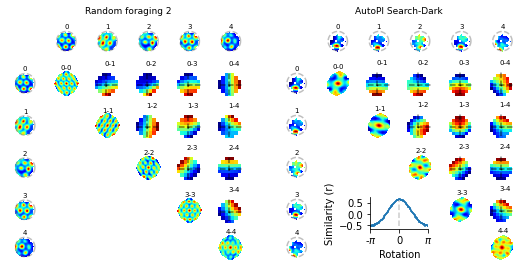

In [37]:
rowSize,colSize= 0.6,0.6 #figurePanelDefaultSize()
nCells=5
ncols=(nCells+1)*2
nrows=(nCells+1)*1
sessionName = "jp1686-26042022-0108" 

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure.
mainSpec = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure

plot_map_and_cross_for_figure(mainSpec,sessionName,gcStcfm,gcStcfmRot,gcStcfm_pairs,nCells)

In [40]:
cellsSimplify = cells[["cluId","gridCell_AND","gridCell_OR"]]
for tw in gcStcfm_pairs.keys():
    for env in gcStcfm_pairs["10-0.5"].keys():
        gcStcfm_pairs[tw][env] = pd.merge(gcStcfm_pairs[tw][env],cellsSimplify,left_on="cluId1",right_on="cluId")
        gcStcfm_pairs[tw][env].columns = ['cluId1', 'cluId2', 'index1', 'index2', 'session', 'mouse', 'spike_n1',
                       'spike_n2', 'spike_count', 'occupancy_sum', 'cluId_n1', 'gridCell_AND_n1',
                       'gridCell_OR_n1']
        gcStcfm_pairs[tw][env] = pd.merge(gcStcfm_pairs[tw][env],cellsSimplify,left_on="cluId2",right_on="cluId")
        gcStcfm_pairs[tw][env].columns = ['cluId1', 'cluId2', 'index1', 'index2', 'session', 'mouse', 'spike_n1',
               'spike_n2', 'spike_count', 'occupancy_sum', 'cluId_n1',
               'gridCell_AND_n1', 'gridCell_OR_n1', 'cluId_n2', 'gridCell_AND_n2',
               'gridCell_OR_n2'] 

In [41]:
# get the grid spacing of one of the neuron in the pair
dfMapStatsSimplify= dfMapStats[dfMapStats.condition=="circ80_1"][["cellId","gridSpacing"]]
for tw in gcStcfm_pairs.keys():
    for env in gcStcfm_pairs["10-0.5"].keys():
       
        gcStcfm_pairs[tw][env] = pd.merge(gcStcfm_pairs[tw][env],dfMapStatsSimplify,left_on="cluId1",right_on="cellId")
       
        gcStcfm_pairs[tw][env].columns=['cluId1', 'cluId2', 'index1', 'index2', 'session', 'mouse', 'spike_n1',
               'spike_n2', 'spike_count', 'occupancy_sum', 'cluId_n1',
               'gridCell_AND_n1', 'gridCell_OR_n1', 'cluId_n2', 'gridCell_AND_n2',
               'gridCell_OR_n2', 'cellId_n1b', 'gridSpacing_n1']

        gcStcfm_pairs[tw][env] = pd.merge(gcStcfm_pairs[tw][env],dfMapStatsSimplify,left_on="cluId2",right_on="cellId")
        gcStcfm_pairs[tw][env].columns = ['cluId1', 'cluId2', 'index1', 'index2', 'session', 'mouse', 'spike_n1',
               'spike_n2', 'spike_count', 'occupancy_sum', 'cluId_n1',
               'gridCell_AND_n1', 'gridCell_OR_n1', 'cluId_n2', 'gridCell_AND_n2',
               'gridCell_OR_n2', 'cellId_n1b', 'gridSpacing_n1', 'cellId_n2b', 'gridSpacing_n2']

In [42]:
def addLabelToDfCross(df):
    df["label"]=np.nan
    df.label[df.condition=='circ80_1-circ80_2'] = "RF1-RF2"
    df.label[df.condition=='circ80_1-searchToLeverPath_light'] = "RF1-SL"
    df.label[df.condition=='circ80_1-searchToLeverPath_dark'] = "RF1-SD"    
    df.label[df.condition=='circ80_1-homingFromLeavingLever_light'] = "RF1-HL"
    df.label[df.condition=='circ80_1-homingFromLeavingLever_dark'] = "RF1-HD"
    
    df.label[df.condition=='circ80_2-searchToLeverPath_light'] = "RF2-SL"
    df.label[df.condition=='circ80_2-searchToLeverPath_dark'] = "RF2-SD"    
    df.label[df.condition=='circ80_2-homingFromLeavingLever_light'] = "RF2-HL"
    df.label[df.condition=='circ80_2-homingFromLeavingLever_dark'] = "RF2-HD"
    
    
    df.label[df.condition=='searchToLeverPath_light-searchToLeverPath_dark'] = "SL-SD"
    df.label[df.condition=='homingFromLeavingLever_light-homingFromLeavingLever_dark'] = "HL-HD"
    df.label[df.condition=='searchToLeverPath_light-homingFromLeavingLever_light'] = "SL-HL"
    df.label[df.condition=='searchToLeverPath_dark-homingFromLeavingLever_dark'] = "SD-HD"
    
    df.label[df.condition=='searchToLeverPath_light_1-searchToLeverPath_light_2'] = "SL1-SL2"
    df.label[df.condition=='searchToLeverPath_dark_1-searchToLeverPath_dark_2'] = "SD1-SD2"
    df.label[df.condition=='homingFromLeavingLever_light_1-homingFromLeavingLever_light_2'] = "HL1-HL2"
    df.label[df.condition=='homingFromLeavingLever_dark_1-homingFromLeavingLever_dark_2'] = "HD1-HD2"
radius_tw = "10-0.5"
comparisons = ['circ80_1-circ80_2',
               'circ80_2-searchToLeverPath_light', 
               'circ80_2-searchToLeverPath_dark', 
               'circ80_2-homingFromLeavingLever_light', 
               'circ80_2-homingFromLeavingLever_dark',
               
               'searchToLeverPath_light-searchToLeverPath_dark', 
               'homingFromLeavingLever_light-homingFromLeavingLever_dark', 
               'searchToLeverPath_light-homingFromLeavingLever_light',
               'searchToLeverPath_dark-homingFromLeavingLever_dark',
               
               'searchToLeverPath_light_1-searchToLeverPath_light_2', 
               'searchToLeverPath_dark_1-searchToLeverPath_dark_2', 
               'homingFromLeavingLever_light_1-homingFromLeavingLever_light_2',
               'homingFromLeavingLever_dark_1-homingFromLeavingLever_dark_2',]
def labelOrderCross():
    return ["RF1-RF2","RF2-SL","RF2-SD", "RF2-HL", "RF2-HD",    "SL-SD","HL-HD", "SL-HL", "SD-HD", "", "SL1-SL2","SD1-SD2","HL1-HL2","HD1-HD2"]

In [43]:
res = pd.DataFrame()


for comp in comparisons:
    env1=comp.split("-")[0]
    env2=comp.split("-")[1]
    
    res = pd.concat([res,pd.DataFrame({"session":gcStcfm_pairs[radius_tw][env1].session,
              "mouse":gcStcfm_pairs[radius_tw][env1].mouse,
              "condition": comp,
              "cluId1": gcStcfm_pairs[radius_tw][env1].cluId1.to_numpy(),
              "cluId2": gcStcfm_pairs[radius_tw][env1].cluId2.to_numpy(),
              "env1": comp.split("-")[0],
              "env2": comp.split("-")[1],
              "env1_spike_n1" : gcStcfm_pairs[radius_tw][env1].spike_n1,
              "env1_spike_n2" : gcStcfm_pairs[radius_tw][env1].spike_n2,
              "env2_spike_n1" : gcStcfm_pairs[radius_tw][env2].spike_n1,
              "env2_spike_n2" : gcStcfm_pairs[radius_tw][env2].spike_n2,
              "env1_occupancy_sum" : gcStcfm_pairs[radius_tw][env1].occupancy_sum,
              "env2_occupancy_sum" : gcStcfm_pairs[radius_tw][env2].occupancy_sum,
              #"circ80_gridSpacing_n1" : gcStcfm_pairs[radius_tw][env1].gridSpacing_n1,
              #"circ80_gridSpacing_n2" : gcStcfm_pairs[radius_tw][env1].gridSpacing_n2,
              "gridCell_AND_n1": gcStcfm_pairs[radius_tw][env1].gridCell_AND_n1,
              "gridCell_AND_n2": gcStcfm_pairs[radius_tw][env1].gridCell_AND_n2,
              "r" : gcStcfmRot[radius_tw][comp][:,35],
              'p': gcStcfm_pairs_stats[radius_tw][comp]['p_values'][:,35],
              'corr': gcStcfm_pairs_stats[radius_tw][comp]['correlation'][:,35],
              #"ifrR":
              "rangeR": gcStcfmRot[radius_tw][comp][:,35] - gcStcfmRot[radius_tw][comp][:,0]})])
res

,session,mouse,condition,cluId1,cluId2,env1,env2,env1_spike_n1,env1_spike_n2,env2_spike_n1,env2_spike_n2,env1_occupancy_sum,env2_occupancy_sum,gridCell_AND_n1,gridCell_AND_n2,r,p,corr,rangeR
0,jp486-18032023-0108,jp486,circ80_1-circ80_2,jp486-18032023-0108_502,jp486-18032023-0108_508,circ80_1,circ80_2,9253,5930,10078,7833,8283.84,9394.72,True,True,0.987000,3.700774e-18,0.987000,1.945289
1,jp486-18032023-0108,jp486,circ80_1-circ80_2,jp486-18032023-0108_502,jp486-18032023-0108_520,circ80_1,circ80_2,9253,4981,10078,6067,8283.84,9394.72,True,True,0.983977,3.281622e-17,0.983977,1.803850
2,jp486-18032023-0108,jp486,circ80_1-circ80_2,jp486-18032023-0108_508,jp486-18032023-0108_520,circ80_1,circ80_2,7835,4700,10156,5817,7073.68,9633.56,True,True,0.990720,1.091930e-19,0.990720,1.878262
3,jp486-18032023-0108,jp486,circ80_1-circ80_2,jp486-18032023-0108_502,jp486-18032023-0108_524,circ80_1,circ80_2,9253,8181,10078,8822,8283.84,9394.72,True,True,0.998611,2.462642e-28,0.998611,1.955444
4,jp486-18032023-0108,jp486,circ80_1-circ80_2,jp486-18032023-0108_508,jp486-18032023-0108_524,circ80_1,circ80_2,7835,8498,10156,9361,7073.68,9633.56,True,True,0.968250,4.023130e-14,0.968250,1.882713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12633,jp3269-24112022-0108,jp3269,homingFromLeavingLever_dark_1-homingFromLeavin...,jp3269-24112022-0108_309,jp3269-24112022-0108_350,homingFromLeavingLever_dark_1,homingFromLeavingLever_dark_2,34,16,47,41,26.74,38.74,True,False,0.085982,7.344367e-01,0.085982,-0.109264
12634,jp452-22112022-0108,jp452,homingFromLeavingLever_dark_1-homingFromLeavin...,jp452-22112022-0108_119,jp452-22112022-0108_164,homingFromLeavingLever_dark_1,homingFromLeavingLever_dark_2,782,664,1205,997,572.30,970.04,False,False,0.193364,3.766908e-01,0.193364,0.214748
12635,jp3129-06062022-0107,jp3129,homingFromLeavingLever_dark_1-homingFromLeavin...,jp3129-06062022-0107_283,jp3129-06062022-0107_285,homingFromLeavingLever_dark_1,homingFromLeavingLever_dark_2,1487,1119,850,573,1207.18,628.14,True,True,0.245220,2.594142e-01,0.245220,0.454242
12636,mn8599-08022022-0107,mn8599,homingFromLeavingLever_dark_1-homingFromLeavin...,mn8599-08022022-0107_44,mn8599-08022022-0107_48,homingFromLeavingLever_dark_1,homingFromLeavingLever_dark_2,234,234,134,141,211.48,116.04,False,False,0.694816,2.814282e-03,0.694816,1.530201


In [44]:
def plotCrossStats(mainSpec):
    plotsSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=3, subplot_spec=mainSpec[0],height_ratios=[1.3,1,1])

    # first plot
    plot1Spec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotsSpec[0])
    ax = fig.add_subplot(plot1Spec[0])
    cross_stability(ax,res,dfShuffle=df,selectGridCellAND=True)

    # second plots
    plot2Spec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotsSpec[1])
    plot_2_matrices_rotation_curves(plot2Spec)

    # third plots
    plot3Spec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotsSpec[2])
    plot_2_rotation_curves(plot3Spec)

In [45]:
minPairsPerMouse = 50
radius_tw = "10-0.5"
comp = 'searchToLeverPath_light-homingFromLeavingLever_light'
pairCounts = gcStcfm_pairs["10-0.5"]["circ80_1"].mouse.value_counts()
mouseSelection = list(pairCounts[pairCounts>minPairsPerMouse].index)
print(pairCounts)
print(mouseSelection)
meanCurve = np.empty((len(res.condition.unique()),len(mouseSelection),72))

myLabels={'circ80_1-circ80_2': "RF1-RF2", 
          'circ80_1-searchToLeverPath_light': "RF1-SL",
       'circ80_1-searchToLeverPath_dark': "RF1-SD",
       'circ80_1-homingFromLeavingLever_light': "RF1-HL",
       'circ80_1-homingFromLeavingLever_dark': "RF1-HD",
          
       'circ80_2-searchToLeverPath_light': "RF2-SL",
       'circ80_2-searchToLeverPath_dark': "RF2-SD",
       'circ80_2-homingFromLeavingLever_light': "RF2-HL",
       'circ80_2-homingFromLeavingLever_dark': "RF2-HD",
          
       'searchToLeverPath_light-searchToLeverPath_dark': "SL-SD",
       'homingFromLeavingLever_light-homingFromLeavingLever_dark':"HL-HD",
       'searchToLeverPath_light-homingFromLeavingLever_light': "SL-HL",
       'searchToLeverPath_dark-homingFromLeavingLever_dark': "SD-HD",
       'searchToLeverPath_light_1-searchToLeverPath_light_2': "SL1-SL2",
       'searchToLeverPath_dark_1-searchToLeverPath_dark_2': "SD1-SD2",
       'homingFromLeavingLever_light_1-homingFromLeavingLever_light_2': "HL1-HL2",
       'homingFromLeavingLever_dark_1-homingFromLeavingLever_dark_2': "HD1-HD2"}


for i, condition in enumerate(res.condition.unique()):
    for j, mouse in enumerate(mouseSelection):
        meanCurve[i,j]= np.nanmean(gcStcfmRot[radius_tw][condition][(gcStcfm_pairs["10-0.5"]["circ80_1"].mouse==mouse)&
                                                                    (gcStcfm_pairs["10-0.5"]["circ80_1"].gridCell_AND_n1==True)&
                                                                    ((gcStcfm_pairs["10-0.5"]["circ80_1"].gridCell_AND_n2==True))],axis=0)

mouse
jp486     8781
jp3269    1094
jp452      810
mn8578     489
jp451      420
jp3120     386
jp3129     151
jp1686     145
jp1084     104
mn8599      82
jp1687      73
jp3130      33
jp1684      24
jp487       20
jp499       20
jp1685       4
jp497        2
Name: count, dtype: int64
['jp486', 'jp3269', 'jp452', 'mn8578', 'jp451', 'jp3120', 'jp3129', 'jp1686', 'jp1084', 'mn8599', 'jp1687']


In [46]:
def plot_cc_rotation_curves_rf(ax,meanCurve,res,plotLegend=True, showYLabel=True, conditions =['circ80_1-circ80_2', 'circ80_2-searchToLeverPath_light',
       'circ80_2-searchToLeverPath_dark', 'circ80_2-homingFromLeavingLever_light','circ80_2-homingFromLeavingLever_dark']):
    for condition in conditions:
        i = [ i for i, cond in enumerate(res.condition.unique()) if cond == condition][0]
        ax.errorbar(x = np.linspace(-np.pi,np.pi,72) , y= meanCurve[i].mean(axis=0) ,  
                    yerr= meanCurve[i].std(axis=0)/np.sqrt(meanCurve[i].shape[0]),
                    label=myLabels[condition])
    ax.plot([0,0],[-0.4,0.5],"--",color="gray",alpha=0.4)
    ax.set_xlabel("Rotation")
    if showYLabel:
        ax.set_ylabel("Similarity (r)")
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-0.75,0.5)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if plotLegend:
        ax.legend(fontsize=6)
def plot_2_rotation_curves(spec):
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, subplot_spec=spec[0])
    ax = fig.add_subplot(plotSpec[0])
    plot_cc_rotation_curves_rf(ax,meanCurve,res,
                          conditions =['circ80_2-searchToLeverPath_light', 
                                       'circ80_2-searchToLeverPath_dark', 
                                       'circ80_2-homingFromLeavingLever_light',
                                       'circ80_2-homingFromLeavingLever_dark'],plotLegend=True)

    ax = fig.add_subplot(plotSpec[1])
    plot_cc_rotation_curves_rf(ax,meanCurve,res,
                          conditions =['searchToLeverPath_light-searchToLeverPath_dark',
                                       'homingFromLeavingLever_light-homingFromLeavingLever_dark',
                                       'searchToLeverPath_light-homingFromLeavingLever_light'],
                           plotLegend=True, showYLabel=False)
    
def plot_matrix_rotation_curves(ax,meanCurve,res,showYLabel=True, condition ='circ80_1-circ80_2'):
    
    i = [ i for i, cond in enumerate(res.condition.unique()) if cond == condition][0]

    ax.imshow(meanCurve[i],aspect="auto",interpolation="None",origin="lower",
             extent=[-np.pi,np.pi,0,meanCurve[i].shape[0]])
    
    env1=condition.split("-")[0]
    env2=condition.split("-")[1]
    ax.set_title("{}".format(myLabels[condition]),fontsize=8)
    
    if showYLabel:
        ax.set_ylabel("Mouse")
    
    ax.set_xlabel("Rotation")
    
    ax.set_yticks(ticks=[])
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])   

def plot_2_matrices_rotation_curves(spec):
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, subplot_spec=spec[0])
    ax = fig.add_subplot(plotSpec[0])
    plot_matrix_rotation_curves(ax,meanCurve,res,showYLabel=True, condition ='circ80_1-circ80_2')
    ax = fig.add_subplot(plotSpec[1])
    plot_matrix_rotation_curves(ax,meanCurve,res,showYLabel=True, condition ='circ80_2-searchToLeverPath_dark')

In [47]:
CROSSSTABILITYCOLOR = ['#FF355E','#FD5B78', '#FF6037', '#FF9966','#FF9933', '#FFCC33',
'#FFFF66','#CCFF00', '#66FF66','#AAF0D1','#16D0CB','#50BFE6','#9C27B0','#EE34D2','#FF00CC']
def cross_stability(ax,dfGridPair,dfShuffle,statUnit="mouse",vd="r",selectGridCellAND=True,ymax=1.0,ymin=-0.5):

    minPairsPerMouse = 50
    pairCounts = gcStcfm_pairs["10-0.5"]["circ80_1"].mouse.value_counts()
    mouseSelection = list(pairCounts[pairCounts>minPairsPerMouse].index)
    
    dfGridPair = dfGridPair[dfGridPair.mouse.isin(mouseSelection)]
    
    if selectGridCellAND:
        dfGridPair = dfGridPair[(dfGridPair.gridCell_AND_n1==True)&(dfGridPair.gridCell_AND_n2==True)]
    
    
    if statUnit=="mouse":
        dfGridPair=dfGridPair.groupby(["condition","mouse"])[vd].median().reset_index()   
    addLabelToDfCross(dfGridPair)
    addLabelToDfCross(dfShuffle)
    
    #sns.violinplot(y="label",x="r",data=dfGrid,inner="quartile",order=labelOrder(),width=1)
    sns.boxplot(data=dfGridPair,y="label",x=vd,showfliers=False,order=labelOrderCross(),palette=CROSSSTABILITYCOLOR)
    ax=sns.boxplot(data=dfShuffle, y='pair', x='median', palette=CROSSSTABILITYCOLOR, boxprops=dict(alpha=.3))
    for line in ax.lines:
        line.set_alpha(0.3)
    #for patch in ax.artists:
    #    fc = patch.get_facecolor()
    #    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.3))
    sns.stripplot(data=dfGridPair, y="label",x=vd,order = labelOrderCross(),alpha=0.5,size=5,linewidth=1,palette=CROSSSTABILITYCOLOR)
    
    ax.tick_params(axis='y', which='major', labelsize=8)
    
    ax.set_xlim(ymin,ymax)
    ax.set_xlabel("S-Trig. map similarity (r)")
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Remove the empty tick
    # # Get the current y-ticks and y-tick labels
    # yticks = ax.get_yticks()
    # yticklabels = [item.get_text() for item in ax.get_yticklabels()]

    # # Remove the 9th tick and its label (index 8, as Python is 0-indexed)
    # if len(yticks) > 8:
    #     yticks = np.delete(yticks, 8)
    #     yticklabels.pop(8)

    # # Set the modified ticks and labels
    # ax.set_yticks(yticks)
    # ax.set_yticklabels(yticklabels)
    
    n = len(dfGridPair.mouse.unique())
    ax.text(0.06, 0.9, f"N = {n}",fontsize=9,transform = ax.transAxes)
    return dfGridPair

In [73]:
data=gcStcfm_shuffle['10-0.5']

def to_numeric_array(arr):
    # Convert the array to a pandas Series, then to numeric, replacing non-numeric with NaN
    return pd.to_numeric(pd.Series(arr), errors='coerce').values

pairs = []
conditions = []
values = []


for pair, conditions_dict in data.items():
     if isinstance(conditions_dict, dict):
        conditions_dict.pop('label', None)
        for condition, array_values in conditions_dict.items():
            pairs.append(pair)
            conditions.append(condition)
            # Convert to numeric array, replacing non-numeric entries with NaN
            numeric_array = to_numeric_array(array_values)
            values.append(numeric_array)

# Create a DataFrame with the flattened lists
df = pd.DataFrame({'pair': pairs, 'condition': conditions, 'values': values})

# Calculate the median for each array in 'values' column, ignoring NaNs
df['median'] = df['values'].apply(np.nanmedian)

# Drop the 'values' column if only the median is needed
df = df.drop(columns=['values'])
addLabelToDfCross(df)
print(df)


                                                   pair condition    median  \
0                                     circ80_1-circ80_2         0  0.090773   
1                                     circ80_1-circ80_2         1  0.102455   
2                                     circ80_1-circ80_2         2  0.090804   
3                                     circ80_1-circ80_2         3  0.094834   
4                                     circ80_1-circ80_2         4  0.091579   
...                                                 ...       ...       ...   
3395  searchToLeverPath_dark-homingFromLeavingLever_...       195 -0.002181   
3396  searchToLeverPath_dark-homingFromLeavingLever_...       196 -0.012297   
3397  searchToLeverPath_dark-homingFromLeavingLever_...       197 -0.000634   
3398  searchToLeverPath_dark-homingFromLeavingLever_...       198  0.001220   
3399  searchToLeverPath_dark-homingFromLeavingLever_...       199 -0.005104   

      label  
0       NaN  
1       NaN  
2       N

,condition,mouse,r,label
0,circ80_1-circ80_2,jp1084,0.890828,RF1-RF2
1,circ80_1-circ80_2,jp1686,0.972254,RF1-RF2
2,circ80_1-circ80_2,jp1687,0.810892,RF1-RF2
3,circ80_1-circ80_2,jp3120,0.971669,RF1-RF2
4,circ80_1-circ80_2,jp3129,0.966829,RF1-RF2
...,...,...,...,...
138,searchToLeverPath_light_1-searchToLeverPath_li...,jp451,0.856875,SL1-SL2
139,searchToLeverPath_light_1-searchToLeverPath_li...,jp452,0.908090,SL1-SL2
140,searchToLeverPath_light_1-searchToLeverPath_li...,jp486,0.797983,SL1-SL2
141,searchToLeverPath_light_1-searchToLeverPath_li...,mn8578,0.883514,SL1-SL2


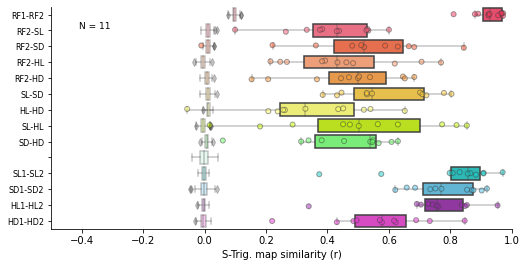

In [75]:
rowSize,colSize= figurePanelDefaultSize()
ncols=4
nrows=2.0
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(mainSpec[0]) 
cross_stability(ax,res,dfShuffle=df,selectGridCellAND=True)

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -4388.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5262 -0.5700 -0.0248  0.5282  5.6773 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001553 0.01246 
 id2      (Intercept) 0.0000000 0.00000 
 Residual             0.0054000 0.07348 
Number of obs: 1868, groups:  id1, 398; id2, 347

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -4.873e-03  1.920e-03  2.118e+02  -2.539   0.0118 *  
ifrAsso_circ80_1  8.118e-01  9.390e-03  1.859e+03  86.449   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.140
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

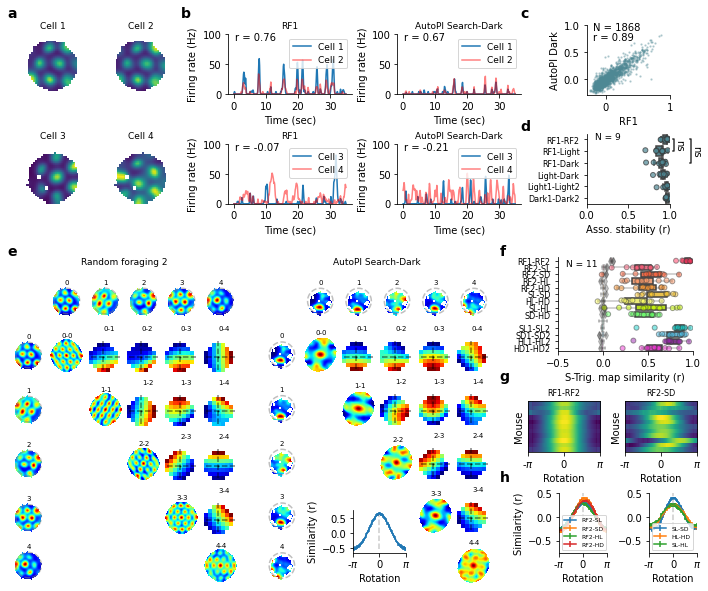

In [77]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5.4
nrows=2+2.5
sessionName = "jp1686-26042022-0108"; nCells=5

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure

mainSpec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=[0.01,4],height_ratios=[0.01,4,0.3,6]) # create a GridSpec object to a figure

# for IFR
plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, width_ratios=[4,1.4] ,subplot_spec=mainSpec[1,1])    
exampleSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotSpec[0])
statsSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=plotSpec[1])
plot_two_ifr_examples(exampleSpec)
plotFiringAssociations(statsSpec[0],dfAsso_sh)

# for example of ST cross-firing rate maps
crossSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1 , width_ratios=[4,0.15,1.6],subplot_spec=mainSpec[3,1])    
crossExampleSpec =  gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1 ,subplot_spec=crossSpec[0,0])    
crossStatsSpec =  gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1 ,subplot_spec=crossSpec[0,2])

plot_map_and_cross_for_figure(crossExampleSpec,sessionName,gcStcfm,gcStcfmRot,gcStcfm_pairs,nCells)
plotCrossStats(crossStatsSpec)


ax = fig.add_subplot(mainSpec[:,:]) # add an axes to the figure
ax.text(0,1, 'a', style='normal',fontsize=14, weight="bold")
ax.text(0.25,1, 'b', style='normal',fontsize=14, weight="bold")
ax.text(0.74,1, 'c', style='normal',fontsize=14, weight="bold")
ax.text(0.74,0.80, 'd', style='normal',fontsize=14, weight="bold")

ax.text(0,0.58, 'e', style='normal',fontsize=14, weight="bold")
ax.text(0.71,0.58, 'f', style='normal',fontsize=14, weight="bold")
ax.text(0.71,0.36, 'g', style='normal',fontsize=14, weight="bold")
ax.text(0.71,0.18, 'h', style='normal',fontsize=14, weight="bold")

ax.axis("off")

Mixed effects model

In [34]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Activate the pandas-to-R conversion
pandas2ri.activate()

# Load R's lme4 package
lme4 = importr('lme4')

# Transfer the DataFrame to R
robjects.globalenv['data'] = dfAsso_sh

# Run the R code for the model
robjects.r('''
    library(lme4)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)


R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -4388.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5262 -0.5700 -0.0248  0.5282  5.6773 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001553 0.01246 
 id2      (Intercept) 0.0000000 0.00000 
 Residual             0.0054000 0.07348 
Number of obs: 1868, groups:  id1, 398; id2, 347

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -4.873e-03  1.920e-03  2.118e+02  -2.539   0.0118 *  
ifrAsso_circ80_1  8.118e-01  9.390e-03  1.859e+03  86.449   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.140
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

In [18]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# Activate the pandas-to-R conversion
pandas2ri.activate()

# Load R's lme4 package
lme4 = importr('lme4')

# Transfer the DataFrame to R
robjects.globalenv['data'] = dfAsso_sh

# Run the R code for the model
robjects.r('''
    library(lmerTest)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
    fixed_effects <- model_summary$coefficients
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)
fixed_effects = robjects.r('fixed_effects')
print(f'r={fixed_effects[1][0]}, p={fixed_effects[1][4]}')


R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -4388.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5262 -0.5700 -0.0248  0.5282  5.6773 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001553 0.01246 
 id2      (Intercept) 0.0000000 0.00000 
 Residual             0.0054000 0.07348 
Number of obs: 1868, groups:  id1, 398; id2, 347

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -4.873e-03  1.920e-03  2.118e+02  -2.539   0.0118 *  
ifrAsso_circ80_1  8.118e-01  9.390e-03  1.859e+03  86.449   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.140
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

In [26]:
# Run the R code for the model
robjects.r('''
    library(lmerTest)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_circ80_2 ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_circ80_2 ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -11368.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.6268 -0.3758 -0.0521  0.3497  9.6099 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 1.130e-04 0.010629
 id2      (Intercept) 1.059e-05 0.003255
 Residual             4.582e-03 0.067693
Number of obs: 4511, groups:  id1, 553; id2, 553

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      1.304e-03  1.187e-03 2.472e+02   1.099    0.273    
ifrAsso_circ80_1 9.118e-01  5.384e-03 4.490e+03 169.345   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.147



In [25]:
# Run the R code for the model
robjects.r('''
    library(lmerTest)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_all_light ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_light ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -9461.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5619 -0.5742 -0.0575  0.5271  6.5426 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0002038 0.01427 
 id2      (Intercept) 0.0001373 0.01172 
 Residual             0.0068640 0.08285 
Number of obs: 4511, groups:  id1, 553; id2, 553

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -1.686e-02  1.594e-03  2.535e+02  -10.58   <2e-16 ***
ifrAsso_circ80_1  9.644e-01  6.643e-03  4.467e+03  145.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.136



In [27]:
# Run the R code for the model
robjects.r('''
    library(lmerTest)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_all_light ~ ifrAsso_all_dark + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_light ~ ifrAsso_all_dark + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -9901.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4408 -0.5997 -0.0775  0.5746  5.1112 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001173 0.01083 
 id2      (Intercept) 0.0001373 0.01172 
 Residual             0.0062691 0.07918 
Number of obs: 4511, groups:  id1, 553; id2, 553

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -8.474e-03  1.467e-03  2.503e+02  -5.778 2.24e-08 ***
ifrAsso_all_dark  1.056e+00  6.869e-03  4.480e+03 153.760  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_ll_d -0.102



In [29]:
# Run the R code for the model
robjects.r('''
    library(lmerTest)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_light_1 ~ ifrAsso_light_2 + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_light_1 ~ ifrAsso_light_2 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -17393.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8018 -0.5223 -0.0271  0.5319  4.1078 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001825 0.01351 
 id2      (Intercept) 0.0001750 0.01323 
 Residual             0.0010250 0.03201 
Number of obs: 4511, groups:  id1, 553; id2, 553

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     2.560e-03  1.055e-03 6.686e+02   2.426   0.0155 *  
ifrAsso_light_2 9.775e-01  2.937e-03 4.268e+03 332.836   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_lg_2 -0.203



In [30]:
# Run the R code for the model
robjects.r('''
    library(lmerTest)
    # Fit the mixed model in R
    model <- lmer(ifrAsso_dark_1 ~ ifrAsso_dark_2 + (1 | id1) + (1 | id2), data = data)
    # Get the summary
    model_summary <- summary(model)
''')

# Retrieve and print the model summary
model_summary = robjects.r('model_summary')
print(model_summary)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_dark_1 ~ ifrAsso_dark_2 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -18298.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7105 -0.5277 -0.0108  0.5098  4.3226 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001147 0.01071 
 id2      (Intercept) 0.0001166 0.01080 
 Residual             0.0008631 0.02938 
Number of obs: 4511, groups:  id1, 553; id2, 553

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    4.687e-05  8.820e-04 6.642e+02   0.053    0.958    
ifrAsso_dark_2 9.816e-01  2.915e-03 4.335e+03 336.752   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_dr_2 -0.189



In [15]:
logging.getLogger("rpy2").setLevel(logging.ERROR)
def plotSingleFiringAsso(ax,dfAsso,cond1,cond2,printStats=False):
    
    # use to set meaningful condition names
    labelDict = {"ifrAsso_circ80_1": "RF1",
                "ifrAsso_circ80_2": "RF2",
                "ifrAsso_all_dark": "AutoPI Dark",
                "ifrAsso_all_light": "AutoPI Light"}
    
    myCol=(0.30588235, 0.53333333, 0.58039216)
    ax.scatter(dfAsso[cond1],dfAsso[cond2],s=2,alpha=0.3,color=myCol)
    ax.set_xlim(-0.3,1)
    ymax=1
    ax.set_ylim(-0.3,ymax)
    ax.set_xlabel(labelDict[cond1])
    ax.set_ylabel(labelDict[cond2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #r,p = pearsonr(dfAsso[cond1],dfAsso[cond2])
    #instead of pearson r use mixed effets model (code in R)
    pandas2ri.activate()
    lme4 = importr('lme4')
    robjects.globalenv['data'] = dfAsso
    robjects.r('''
        library(lmerTest)
        # Fit the mixed model in R
        model <- lmer(ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2), data = data)
        # Get the summary
        model_summary <- summary(model)
        fixed_effects <- model_summary$coefficients
    ''')
    model_summary = robjects.r('model_summary')
    print(model_summary)
    fixed_effects = robjects.r('fixed_effects')
    print(f'r={fixed_effects[1][0]}, p={fixed_effects[1][4]}')
    r=fixed_effects[1][0]; p=fixed_effects[1][4]
    n = len(dfAsso[cond1])
    
    ax.text(-0.2, ymax*0.90, "N = {}".format(n),fontsize=10)
    ax.text(-0.2, ymax*0.72, "r = {:.2f}".format(r),fontsize=10)
    if printStats:
        print("N:{}, r:{}, p:{}".format(n,r,p))
    

In [16]:
data=dfAsso_sh

conds1 = ["ifrAsso_circ80_1","ifrAsso_circ80_1","ifrAsso_circ80_1","ifrAsso_all_light","ifrAsso_all_dark_1","ifrAsso_all_light_1"]
conds2 = ["ifrAsso_circ80_2","ifrAsso_all_dark","ifrAsso_all_light","ifrAsso_all_dark","ifrAsso_all_dark_2","ifrAsso_all_light_2"]

dfCounts = data.groupby(["mouse"])["mouse"].value_counts()
mice = [ i for i in dfCounts.index]
dfN = pd.DataFrame({"mouse":mice,
             "n":dfCounts.to_numpy()})
miceToKeep = dfN.mouse[dfN.n>10] # keep mice with at least 10 grid cell pairs

# Activate automatic conversion of pandas DataFrames to R data frames
pandas2ri.activate()

# Load lme4 package in R
lme4 = importr("lme4")

# Initialize an empty list to store results
results = []

# Function to calculate fixed effect for each condition pair within each mouse group
def calculate_fixed_effects(group, cond1, cond2):
    pandas2ri.activate()
    #lme4 = importr('lme4')
    robjects.globalenv['data'] = group
    formula = Formula(f"{cond2} ~ {cond1} + (1 | id1) + (1 | id2)")
    lme4 = importr("lmerTest")
    ## Fit the mixed-effects model using the dynamic formula
    robjects.r(f"model <- lmer('{formula}', data = data)")
    fixed_effect = robjects.r("coef(summary(model))")
    return(fixed_effect[1][0])

dfMouseUnit = pd.DataFrame()
for c1,c2 in zip(conds1,conds2):
    df = dfAsso[[c1,c2, "mouse", "id1", "id2"]]
    df = df[df.mouse.isin(miceToKeep)]

    # Group by mouse and apply the mixed-effects model on each group
    for mouse, group in df.groupby('mouse'):
        # Calculate the fixed effect for each mouse and condition pair
        fixed_effect = calculate_fixed_effects(group, c1, c2)
        
        # Append the results
        results.append({
            "mouse": mouse,
            "condition": f"{c1}-{c2}",
            "fixed_effect_estimate": fixed_effect
        })

results_df = pd.DataFrame(results)
print(results_df)

     mouse                                condition  fixed_effect_estimate
0   jp1084        ifrAsso_circ80_1-ifrAsso_circ80_2               0.917437
1   jp1686        ifrAsso_circ80_1-ifrAsso_circ80_2               0.960739
2   jp3120        ifrAsso_circ80_1-ifrAsso_circ80_2               0.869151
3   jp3129        ifrAsso_circ80_1-ifrAsso_circ80_2               1.117818
4   jp3269        ifrAsso_circ80_1-ifrAsso_circ80_2               0.833581
5    jp451        ifrAsso_circ80_1-ifrAsso_circ80_2               0.867708
6    jp452        ifrAsso_circ80_1-ifrAsso_circ80_2               0.958855
7    jp486        ifrAsso_circ80_1-ifrAsso_circ80_2               0.924965
8   mn8578        ifrAsso_circ80_1-ifrAsso_circ80_2               0.925378
9   jp1084        ifrAsso_circ80_1-ifrAsso_all_dark               0.744373
10  jp1686        ifrAsso_circ80_1-ifrAsso_all_dark               0.715023
11  jp3120        ifrAsso_circ80_1-ifrAsso_all_dark               0.848088
12  jp3129        ifrAsso

In [17]:
custom_long_name = 'Wilcoxon Test'
custom_short_name = 'Wilcoxon'
custom_func = wilcoxon
custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

def plotFiringAssoPerMouseAndConditions(ax,dfMouseUnit,printStats=False, stats_test='Mann-Whitney'):

    addLabelToDfAsso(dfMouseUnit)

    #sns.boxplot(y="label",x="r", data = dfMouseUnit,order=labelOrderAsso())
    #sns.stripplot(data=dfMouseUnit, y="label",x="r",order = labelOrderAsso(),alpha=0.7)
    
    myCol=(0.30588235, 0.53333333, 0.58039216)
    sns.boxplot(data=dfMouseUnit ,y="label",x="fixed_effect_estimate",showfliers=False,order=labelOrderAsso(),color=myCol)
    sns.stripplot(data=dfMouseUnit, y="label",x="fixed_effect_estimate",order = labelOrderAsso(),alpha=0.7,color=myCol,
                   size=5,edgecolor='#373737', linewidth=1)
    
    ax.set_xlim(-0.0,1.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Asso. stability")
    ax.set_ylabel("")
    ax.tick_params(axis='y', which='major', labelsize=8)

    n = len(dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-RF2"]) 
    ax.text(0.10, 0, f"N = {n}",fontsize=9)
    
    # statistics
    if printStats:
        pairs=[('RF1-RF2','RF1-Light'), ('RF1-RF2','RF1-Dark')]
        number_of_comparisons=15 #BH correction for 15 possible comparisons
        annotator = Annotator(ax, data=dfMouseUnit, pairs=pairs, x='fixed_effect_estimate', y="label", order=labelOrderAsso(), orient='h')
        annotator.configure(test=stats_test, loc='outside', line_height=0.01, text_offset=0.001, line_offset=0.001,verbose=2,
                            pvalue_thresholds=[[(1e-4)/number_of_comparisons, "****"], [(1e-3)/number_of_comparisons, "***"], 
                                               [(1e-2)/number_of_comparisons, "**"], [0.05/number_of_comparisons, "*"], [1,"ns"]])
        #annotator.apply_and_annotate()
        
    if printStats:
        s,p1 = wilcoxon(dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-Dark"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs RF1-Dark")
        print("N={} S={} {}".format(n,s,formatPValue(p1)))

        s,p2 = wilcoxon(dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-Light"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs RF1-Light")
        print("N={} S={} {}".format(n,s,formatPValue(p2)))

        s,p = wilcoxon(dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="Light-Dark"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs Light-Dark")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
        s,p = wilcoxon(dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="Light1-Light2"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs Light1-Light2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))
        
        s,p = wilcoxon(dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="RF1-RF2"],dfMouseUnit["fixed_effect_estimate"][dfMouseUnit.label=="Dark1-Dark2"])
        print("Statistics map sim, Wilcoxon, RF1-RF2 vs Dark1-Dark2")
        print("N={} S={} {}".format(n,s,formatPValue(p)))

        
def calculate_fixed_effects(group,cond1,cond2):
    pandas2ri.activate()
    #lme4 = importr('lme4')
    robjects.globalenv['data'] = group
    formula = Formula(f"{cond2} ~ {cond1} + (1 | id1) + (1 | id2)")
    lme4 = importr("lmerTest")
    ## Fit the mixed-effects model using the dynamic formula
    robjects.r(f"model <- lmer('{formula}', data = data)")
    model_summary = robjects.r['summary'](model)
    fixed_effect = robjects.r("coef(summary(model))")
    return(fixed_effect[1][0])


def addLabelToDfAsso(df):
    df["label"]=np.nan
    df.label[df.condition=='ifrAsso_circ80_1-ifrAsso_circ80_2'] = "RF1-RF2"   
    df.label[df.condition=='ifrAsso_circ80_1-ifrAsso_all_dark'] = "RF1-Dark"   
    df.label[df.condition== 'ifrAsso_circ80_1-ifrAsso_all_light'] = "RF1-Light"
    df.label[df.condition=='ifrAsso_all_light-ifrAsso_all_dark'] = "Light-Dark"    
    df.label[df.condition=="ifrAsso_all_dark_1-ifrAsso_all_dark_2"] = "Dark1-Dark2"    
    df.label[df.condition=="ifrAsso_all_light_1-ifrAsso_all_light_2"] = "Light1-Light2"    

def labelOrderAsso():
    return ["RF1-RF2","RF1-Light","RF1-Dark","Light-Dark","Light1-Light2","Dark1-Dark2"]



In [18]:
def plotFiringAssociations(mainSpec,dfAsso):
    
    ncols=1
    nrows=2
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=mainSpec) # two rows to give space for letters above the plots
            
    #ax = fig.add_subplot(plotSpec[0,0]) # add an axes to the figure
    #plotSingleFiringAsso(ax,dfAsso,cond1 = "ifrAsso_circ80_1",cond2 = "ifrAsso_circ80_2")

    ax = fig.add_subplot(plotSpec[0]) # add an axes to the figure
    plotSingleFiringAsso(ax,dfAsso,cond1 = "ifrAsso_circ80_1",cond2 = "ifrAsso_all_dark", printStats=True)

    ax = fig.add_subplot(plotSpec[1]) # add an axes to the figure
    plotFiringAssoPerMouseAndConditions(ax,results_df, printStats=True, stats_test=custom_test)

    #ax = fig.add_subplot(titleSpec[0]) # add an axes to the letters
    #ax.text(0.0,1.0, 'a', style='normal',fontsize=12, weight="bold")
    #ax.text(0.66,1.0, 'b', style='normal',fontsize=12, weight="bold")
    #ax.axis("off")
    

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ifrAsso_all_dark ~ ifrAsso_circ80_1 + (1 | id1) + (1 | id2)
   Data: data

REML criterion at convergence: -4388.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5262 -0.5700 -0.0248  0.5282  5.6773 

Random effects:
 Groups   Name        Variance  Std.Dev.
 id1      (Intercept) 0.0001553 0.01246 
 id2      (Intercept) 0.0000000 0.00000 
 Residual             0.0054000 0.07348 
Number of obs: 1868, groups:  id1, 398; id2, 347

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      -4.873e-03  1.920e-03  2.118e+02  -2.539   0.0118 *  
ifrAsso_circ80_1  8.118e-01  9.390e-03  1.859e+03  86.449   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ifrAss_80_1 -0.140
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

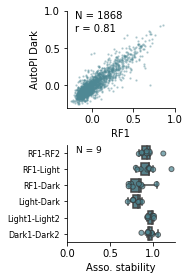

In [20]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1.4
nrows=2
fig = plt.figure(figsize=(ncols*colSize, (nrows+0.1)*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1) # create a GridSpec object to a figure
plotFiringAssociations(mainSpec[0],dfAsso_sh)

In [14]:
pd.set_option('display.max_rows', None)
a = dfAsso[dfAsso.ifrAsso_circ80 >= 0.7] # to find pairs
a = dfAsso[(dfAsso.ifrAsso_circ80 < 0) & (dfAsso.session=='jp486-19032023-0108')]
#a

In [ ]:
#this is just a test
fn=myProject.dataPath+f"/results/gc_crosscorrs_10_0.5_shuffle2.pickle"
print("Loading:",fn)
with open(fn, 'rb') as fp: 
    gcStcfm_noshuffle = pickle.load(fp)

Loading: /adata/projects/autopi_mec/results/gc_crosscorrs_10_0.5_shuffle2.pickle


In [43]:
data=gcStcfm_noshuffle['10-0.5']

def to_numeric_array(arr):
    # Convert the array to a pandas Series, then to numeric, replacing non-numeric with NaN
    return pd.to_numeric(pd.Series(arr), errors='coerce').values

pairs = []
conditions = []
values = []

for pair, conditions_dict in data.items():
    for condition, array_values in conditions_dict.items():
        pairs.append(pair)
        conditions.append(condition)
        # Convert to numeric array, replacing non-numeric entries with NaN
        numeric_array = to_numeric_array(array_values)
        values.append(numeric_array)

# Create a DataFrame with the flattened lists
df = pd.DataFrame({'pair': pairs, 'condition': conditions, 'values': values})

# Calculate the median for each array in 'values' column, ignoring NaNs
df['median'] = df['values'].apply(np.nanmedian)

# Drop the 'values' column if only the median is needed
df = df.drop(columns=['values'])

print(df)


                                                 pair condition    median
0                                   circ80_1-circ80_2         0  0.916857
1                                   circ80_1-circ80_2         1  0.916857
2                    circ80_1-searchToLeverPath_light         0  0.402220
3                    circ80_1-searchToLeverPath_light         1  0.402220
4                     circ80_1-searchToLeverPath_dark         0  0.451571
5                     circ80_1-searchToLeverPath_dark         1  0.451571
6               circ80_1-homingFromLeavingLever_light         0  0.393680
7               circ80_1-homingFromLeavingLever_light         1  0.393680
8                circ80_1-homingFromLeavingLever_dark         0  0.396286
9                circ80_1-homingFromLeavingLever_dark         1  0.396286
10                   circ80_2-searchToLeverPath_light         0  0.378460
11                   circ80_2-searchToLeverPath_light         1  0.378460
12                    circ80_2-searchT

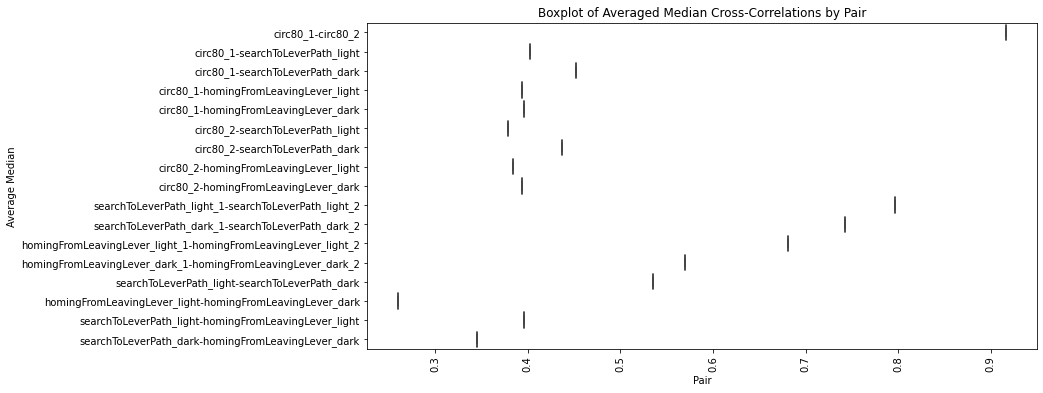

In [48]:
# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y='pair', x='median')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Boxplot of Averaged Median Cross-Correlations by Pair')
plt.ylabel('Average Median')
plt.xlabel('Pair')
plt.show()


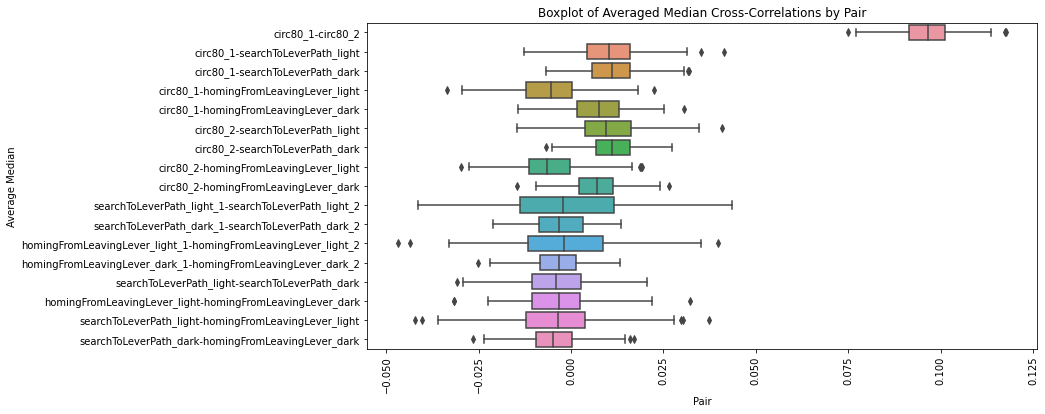

In [31]:
# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y='pair', x='median')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title('Boxplot of Averaged Median Cross-Correlations by Pair')
plt.ylabel('Average Median')
plt.xlabel('Pair')
plt.show()

In [27]:
gcStcfmRot['10-0.5'].keys()

dict_keys(['circ80_1-circ80_2', 'circ80_1-searchToLeverPath_light', 'circ80_1-searchToLeverPath_dark', 'circ80_1-homingFromLeavingLever_light', 'circ80_1-homingFromLeavingLever_dark', 'circ80_2-searchToLeverPath_light', 'circ80_2-searchToLeverPath_dark', 'circ80_2-homingFromLeavingLever_light', 'circ80_2-homingFromLeavingLever_dark', 'searchToLeverPath_light_1-searchToLeverPath_light_2', 'searchToLeverPath_dark_1-searchToLeverPath_dark_2', 'homingFromLeavingLever_light_1-homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark_1-homingFromLeavingLever_dark_2', 'searchToLeverPath_light-searchToLeverPath_dark', 'homingFromLeavingLever_light-homingFromLeavingLever_dark', 'searchToLeverPath_light-homingFromLeavingLever_light', 'searchToLeverPath_dark-homingFromLeavingLever_dark'])

In [23]:
gcStcfm_pairs['10-0.5']['circ80_1']

,cluId1,cluId2,index1,index2,session,mouse,spike_n1,spike_n2,spike_count,occupancy_sum
0,jp486-18032023-0108_502,jp486-18032023-0108_508,0,1,jp486-18032023-0108,jp486,9253,5930,35675,8283.84
1,jp486-18032023-0108_502,jp486-18032023-0108_520,0,2,jp486-18032023-0108,jp486,9253,4981,28455,8283.84
2,jp486-18032023-0108_502,jp486-18032023-0108_524,0,3,jp486-18032023-0108,jp486,9253,8181,45544,8283.84
3,jp486-18032023-0108_502,jp486-18032023-0108_528,0,4,jp486-18032023-0108,jp486,9253,7956,46883,8283.84
4,jp486-18032023-0108_502,jp486-18032023-0108_532,0,5,jp486-18032023-0108,jp486,9253,9136,58730,8283.84
...,...,...,...,...,...,...,...,...,...,...
0,jp3269-24112022-0108_309,jp3269-24112022-0108_350,0,1,jp3269-24112022-0108,jp3269,2628,551,2281,2455.96
0,jp452-22112022-0108_119,jp452-22112022-0108_164,0,1,jp452-22112022-0108,jp452,67187,11010,374667,63466.68
0,jp3129-06062022-0107_283,jp3129-06062022-0107_285,0,1,jp3129-06062022-0107,jp3129,12074,12102,68357,11650.20
0,mn8599-08022022-0107_44,mn8599-08022022-0107_48,0,1,mn8599-08022022-0107,mn8599,7546,3670,49141,7210.54
